# The Boundary Element Method (BEM)


You can run this code directly in your browser by clicking on the rocket logo ( <i class="fas fa-rocket"></i> ) at the top of the page, and clicking 'Binder'. This will open a Jupyter Notebook in a [Binder](https://mybinder.org/) environment which is set up to contain everything you need to run the code. **Don't forget to save a local copy if you make any changes!**

If you prefer, you can download the Jupyter Notebook file to run locally, by clicking the download logo ( <i class="fas fa-download"></i> ) at the top of the page and selecting '.ipynb'.

If you are new to using Jupyter Notebooks, [this guide](https://www.dataquest.io/blog/jupyter-notebook-tutorial/) will help you get started.


## Prerequisites

To understand the basic principles explained in this tutorial, you should:
* (Maths) Have an understanding of the exterior Helmholtz scattering problem
* (Maths) Have a basic understanding of the midpoint rule, for approximating integrals
* (Python) Be comfortable using ```numpy```


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Step one: Obtain a representation for the solution in terms of boundary data

Our starting point is the representation:
$$
u(x) = u^i(x) - \int_{\partial\Omega} \left[\Phi(x,y)\frac{\partial u}{\partial n}(y) - \frac{\partial \Phi(x,y)}{\partial n(y)}u(y)\right]~\mathrm{d}s(y),\quad x\in\mathbb{R}^n\setminus\Omega,
$$
where $\frac{\partial}{\partial n}$ denotes the outward normal derivative, $\partial\Omega$ denotes the boundary of $\Omega$, and $\Phi$ denotes the fundamental solution
$$
\Phi(x,y) = \left\{
\begin{array}{ll}
\frac{\mathrm{i}}{4}H^{(1)}_0(k|x-y|),&\quad n=2,\\
\frac{\mathrm{e}^{\mathrm{i}k|x-y|}}{4\pi|x-y|},&\quad n=3,
\end{array}
\right.
$$
where $H^{(1)}_0$ is the [Hankel function](https://mathworld.wolfram.com/HankelFunctionoftheFirstKind.html) of the first kind order zero. You probably recognise the function for $n=3$, but if you haven't seen $H^{(1)}_0$ before, it looks like the ripples on the surface of a lake after you drop a pebble into the water:

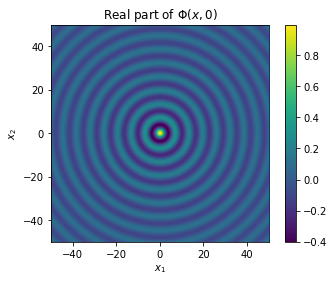

In [8]:
from scipy.special import hankel1 as H1
t = np.linspace(-50,50,1000)
X,Y = np.meshgrid(t,t)
ripples = plt.imshow(np.real(H1(0,np.sqrt(X**2+Y**2))),extent =[t.min(), t.max(), t.min(), t.max()])
plt.colorbar(ripples)
plt.title('Real part of $\Phi(x,0)$');
plt.xlabel("$x_1$")
plt.ylabel("$x_2$");

For this simple example, we will consider scattering by a circle in two-dimensions, with sound-soft aka Dirichlet boundary conditions. This means that $u=0$ on $\Gamma$, so the BIE above simplifies to
$$
u(x) = u^i(x) - \int_\Gamma \Phi(x,y)\frac{\partial u}{\partial n}(y)~\mathrm{d}s(y),\quad x\in\mathbb{R}^2\setminus\Omega.
$$
The integral may be interpreted as lots of tiny speakers $\Phi(x,y)$ on our surface $\Gamma$, whilst $\frac{\partial u}{\partial n}(y)$ can be interpreted as the volume of these speakers. We will choose our incoming wave to be an incident plane wave, $u^i(x)=\mathrm{e}^{\mathrm{i} k x\cdot d}$, where $d\in\mathbb{R}^2$ is a unit vector which represents the direction of propagation.

In [3]:
k = 5.0 # wavenumber
d = np.array([1.0,0.0]) # incident direction

In [4]:
Phi = lambda x,y: 1j/4*H1(0,k*np.linalg.norm(np.array(x)-np.array(y)))
ui = lambda x: np.exp(1j*k*np.dot(x,d))

## Step two: Reformulate as a problem on the boundary $\Gamma$
Remember, our long-term aim is to approximate $\frac{\partial u}{\partial n}$, then we can plug that approximation into the above equation, to obtain an approximation for $u(x)$. To get an equation we can solve, we take the limit of the above equation as $x$ tends to $\Gamma$ and rearrange, to obtain a **boundary integral equation** (BIE):
$$
\int_{\partial\Omega} \Phi(x,y)\frac{\partial u}{\partial n}(y)~\mathrm{d}s(y)=u^i(x),\quad x\in{\partial\Omega}.
$$
A BEM is an approximation of an equation of this type, defined on the boundary ${\partial\Omega}$. Before approximating, we can parametrise the circle ${\partial\Omega}$ by $\theta\in[0,2\pi)\to x\in{\partial\Omega}$ in the natural way, $x(\theta)=[\cos(\theta),\sin(\theta)]$, to rewrite the above BIE in terms of a one-dimensional parameter
$$
\int_0^{2\pi} \tilde\Phi(\theta,\vartheta)\frac{\partial u}{\partial n}(y(\vartheta))~\mathrm{d}\vartheta=u^i(x(\theta)),\quad \theta\in[0,2\pi),
$$
where $\tilde\Phi(\theta,\vartheta):=\Phi(x(\theta),y(\vartheta))$ is purely to keep things a bit simpler.
There are many BEMs, but for the purpose of this example, I will choose the simplest one I can think of.

In [5]:
circle_map = lambda theta: [np.cos(theta), np.sin(theta)]
ui_angular = lambda theta: ui(circle_map(theta))
Phi_tilde = lambda theta,vartheta: Phi(circle_map(theta),circle_map(vartheta))

## Step three: Approximate the boundary data

Choose $N$ equispaced points on the circle $\theta_n=nh$ where $h:=2\pi/N$ for $n=0,\ldots,N-1$. For our approximation, we specify that the above BIE must hold exactly at these points. This is known as a **collocation  BEM**, and $\theta_n$ are the **collocation points**:
$$
\int_0^{2\pi} \tilde\Phi(\theta_n,\vartheta)v_h(\vartheta)~\mathrm{d}\vartheta=u^i(x(\theta_n)),\quad n=0,\ldots,N-1,
$$
where we choose the details of our approximation $v^{(h)}(\theta)\approx\frac{\partial u}{\partial n}(y(\theta))$ next.

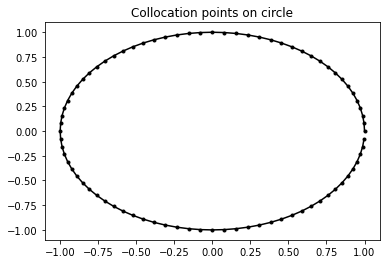

In [6]:
N=80 # number of collocation points
theta = np.linspace(0,2*np.pi,N,endpoint=False) # equispaced points on circle
h = 2*np.pi/N # meshwidth
plt.plot(np.cos(theta),np.sin(theta),'k.-')
plt.title('Collocation points on circle');

 We will use a [piecewise constant](https://mathworld.wolfram.com/PiecewiseConstantFunction.html) approximation $v^{(h)}(\theta)$, such that $v^{(h)}(\theta)=v_m$ for  $\theta\in[\theta_m-h/2,\theta_m+h/2]$ and $v^{(h)}(\theta)=0$ otherwise, for $m=1,\ldots,N$. Note that the values $v_m$ are currently unknown. A piecewise constant approximation is sometimes referred to as $h$-BEM. So the full name of this method is **collocation $h$-BEM**, and it can be expressed in the following form:
$$
\sum_{m=1}^Nv_m\int_{\theta_m-h/2}^{\theta_m+h/2} \tilde\Phi(\theta_n,\vartheta)~\mathrm{d}\vartheta=u^i(x(\theta_n)),\quad n=0,\ldots,N-1.
$$
We can represent the above equation as a linear system for the unknowns $v_m$:
$$A\mathbf{v}=\mathbf{u},$$
where $A_{mn}:=\int_{\theta_m-h/2}^{\theta_m+h/2}\tilde\Phi(\theta_m,\vartheta)~\mathrm{d}\vartheta$, and $u_n := u^i(x(\theta_n))$. Even in this simple example, I hope it is clear that efficient methods for evaluating singular integrals play a key role in BEMs. The Nystrom variant of BEM is fast and simple (perfect for this example). The idea is to approximate (almost) each integral $A_{mn}:=\int_{\theta_m-h/2}^{\theta_m+h/2}\tilde\Phi(\theta_n,\vartheta)~\mathrm{d}\vartheta$ by a one-point quadrature rule, which means we can use our collocation points as our quadrature points. This gives 
$$A_{mn}= h\tilde\Phi(\theta_n,\theta_m)+O(h^2),\quad\text{for }m\neq n,$$
where $O(h^2)$ means the error is bounded above by $Ch^2$, for some constant $C$ and sufficiently small $h$.

But we must be careful, a one-point quadrature rule for $m=n$ gives $h\Phi(\theta_n,\theta_m)=\infty$, since the Hankel function is unbounded at zero! So we need something a little more sophisticated for the diagonal elements.

From DLMF [(10.4.3)](https://dlmf.nist.gov/10.4.3), [(10.8.2)](https://dlmf.nist.gov/10.8.2), [(10.2.2)](https://dlmf.nist.gov/10.2#E2), we can consider the first term in the asymptotic expansion of the Hankel function, integrate the $\log$ exactly, to write
$$
\int_{\theta_n-h/2}^{\theta_m+h/2}\tilde\Phi(\theta_m,\vartheta)~\mathrm{d}\vartheta
=
\frac{\mathrm{i}h\left(2\mathrm{i}\gamma+2\mathrm{i}\log(hk/4)+\mathrm{i}\pi-2\mathrm{i}\right)}{4\pi}+O(h^{2-\epsilon})
$$
where $\gamma\approx0.577$ is Euler's number and $\epsilon$ is any number in $(0,1)$.

Now we can construct the matrix $A$:

In [7]:
eulergamma = 0.57721566
singular_diagonal = lambda h: 1j*h*(2j*eulergamma + 2j*np.log(h*k/4)+1j*np.pi-2j)/(4*np.pi)

# construct matrix
A = np.zeros((N,N),dtype=complex)
for n in range(N):
    for m in range(N):
        if n==m:
            A[m,n] = singular_diagonal(h)
        else:
            A[m,n] = h*Phi_tilde(theta[n],theta[m])

# construct right-hand side vector
u = np.zeros(N,dtype=complex)
for n in range(N):
    u[n] = ui_angular(theta[n])
    
# solve linear system to get values of piecewise constant approximation:
v = np.linalg.solve(A,u)

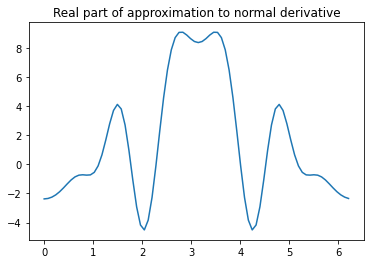

In [8]:
plt.plot(theta,np.real(v))
plt.title('Real part of approximation to normal derivative');

## Step four: Use approximate boundary data in representation formula

Specifically: we will use the approximate boundary data **from step three** in the representation formula **from step one**.

Plugging $v_h$ into the representation formula, and paramerising in the same way as before, gives
$$
u(x) \approx u_h(x) := u^i(x) - \int_0^{2\pi}\Phi(x,y(\theta))v_h(\theta)~\mathrm{d}\theta,\quad x\in\mathbb{R}^2\setminus\Omega.
$$
To be quick, we can use a one-point quadrature rule to evaluate this integral:
$$
u_h(x)\approx u^i(x) - h\sum_{m=1}^Nv_n\Phi(x,y(\theta_m)),\quad x\in\mathbb{R}^2\setminus\Omega.
$$

In [9]:
# create a method which approximates the solution at a point in the scattering domain
def sol_approx(x):
    val = ui(x)
    for n in range(N):
        val -= h*Phi(x,circle_map(theta[n]))*v[n]
    return val

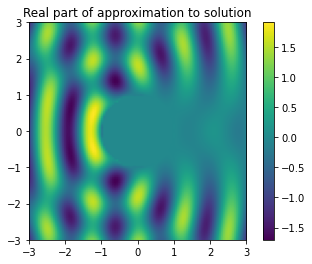

In [10]:
num_pixels =  100
t = np.linspace(-3,3,num_pixels)
X,Y = np.meshgrid(t,t)
u_h = np.zeros((num_pixels,num_pixels),dtype=complex)
for i in range(num_pixels):
    for j in range(num_pixels):
        if (X[i,j]**2+Y[i,j]**2)>1:
            u_h[i,j]=sol_approx([X[i,j],Y[i,j]])
        
sol = plt.imshow(np.real(u_h),extent =[t.min(), t.max(), t.min(), t.max()])
plt.colorbar(sol)
plt.title('Real part of approximation to solution');